In [1]:
# load dependencies
from fastai.imports import *
from fastai.text import *
from fastai.tabular import *
from fastai.text.data import *
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
# extend torch.utils.data.dataset.Dataset to provide us with x1 and x2
# x1 will be used for the tabular submodule and x2 for the text submodule
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): self.x1, self.x2, self.y = x1, x2, y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return (self.x1[i], self.x2[i]), self.y[i]

    
# define a custom collate function to be used to create a Concat DataBunch later
def tabtext_collate(batch):
    x, y = list(zip(*batch))
    # x1 is (cat,cont), x2 is numericalized ids for text
    x1, x2 = list(zip(*x))
    x1 = to_data(x1)
    x1 = list(zip(*x1))
    x1 = torch.stack(x1[0]), torch.stack(x1[1])
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1, x2), y


In [3]:
# setup path variables to load data and save intermediate files
DATA_PATH = Path('./input')
MODEL_LM_PATH = Path('models_lm')
MODEL_LM_PATH.mkdir(exist_ok=True)
MODEL_TEXT_TAB_PATH = Path('models_text_tab')
MODEL_TEXT_TAB_PATH.mkdir(exist_ok=True)

In [4]:
## load data
df_train = pd.read_csv(DATA_PATH/'train.csv')
df_train = df_train.head(5000)

df_train['Title'] = df_train['Title'].str.lower()
df_train['FullDescription'] = df_train['FullDescription'].str.lower()
df_train['LocationNormalized'] = df_train['LocationNormalized'].str.lower()
df_train['ContractType'] = df_train['ContractType'].str.lower()
df_train['Company'] = df_train['Company'].str.lower()
df_train['ContractTime'] = df_train['ContractTime'].str.lower()
df_train['Category'] = df_train['Category'].str.lower()

print(df_train['SalaryNormalized'].max() - df_train['SalaryNormalized'].min())

df_train['SalaryNormalized'] = (df_train['SalaryNormalized'] - df_train['SalaryNormalized'].min()) / (df_train['SalaryNormalized'].max() - df_train['SalaryNormalized'].min())    

f = lambda x: ' '.join([item for item in x.split() if "**" not in item])
df_train["FullDescription"] = df_train["FullDescription"].apply(f)

df_train, df_valid = train_test_split(df_train, test_size=0.2)

print(f'{df_train.shape[0]} datapoints in training set')
print(f'{df_valid.shape[0]} datapoints in validation set')

# bring data in the right format to convert it to a fastai Databunch
df_all = pd.concat([df_train, df_valid]).reset_index(drop=True)
df_all.fillna('', inplace=True)


print(f'{df_all.shape[0]} datapoints in full set')

# save indexes of validation datapoints
val_idxs = np.arange(df_train.shape[0], df_all.shape[0])

df_all['LocationNormalized'] = df_all['LocationNormalized'].rank(method='dense', ascending=False).astype(int)
df_all['Title'] = df_all['Title'].rank(method='dense', ascending=False).astype(int)
df_all['ContractType'] = df_all['ContractType'].rank(method='dense', ascending=False).astype(int)
df_all['Company'] = df_all['Company'].rank(method='dense', ascending=False).astype(int)
df_all['ContractTime'] = df_all['ContractTime'].rank(method='dense', ascending=False).astype(int)
df_all['Category'] = df_all['Category'].rank(method='dense', ascending=False).astype(int)


144816
4000 datapoints in training set
1000 datapoints in validation set
5000 datapoints in full set


In [5]:
# set batch size
bs = 32

# create Databunch (https://docs.fast.ai/text.data.html)
data_lm = (TextList.from_df(df_all, cols=['FullDescription'])
                           .split_by_idx(val_idxs)
                           .label_for_lm()  
                           .databunch(path=MODEL_LM_PATH, bs=bs))

C:\Users\rishu\anaconda3\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [6]:
data_lm.show_batch()

idx,text
0,"for high integrity electronic and electromechanical systems awareness of space / aerospace standards such as xxunk and or similar strong customer facing skills able to work in an sme and utilise multiple skills ideally auditing techniques developed and implemented product assurance plans and procedures ability to undergo uk security clearance this key role involves contribution towards projects , bids and divisional activities for assurance and certification , quality plans ,"
1,". it is not essential to have a financial background although this may help . this is a self employed position . these positions are available now . for that next step and for more details , apply now . xxbos vanrath are currently recruiting a successful telesales executive on behalf of their client a leading design house . the client is going through a a well thought out structured"
2,"register with us . xxbos our client based in london city centre requires a german speaking telesales person with experience of selling b2b . candidates should have a proven track record in working in a similar role . basic salary of pa and commission . this role will involve selling promotional products to businesses in germany , xxunk etc . it is essential candidates speak native level german . recruitment"
3,"modern chef who can create fantastic products which are creative , xxunk mouth xxunk and also have a retail sale element to them . we are looking for some traditional items with a modern twist xxunk xxunk will need to be done daily along with singular products . the remit is to work within a bakery environment so you will also need to be able to produce homemade breads including"
4,") . duties and responsibilities : deliver training to apprentices provide expertise on all aspects of electrical engineering convey knowledge of motors , starters , electrical circuits teaching and assessing learners candidate requirements : electrical experience within industry ideally some teaching / training experience experience and knowledge of basic plc s and drives is an advantage xxbos the company our client is a leading technical recruitment agency and talent management"


In [7]:
data_lm.save('data_lm.pkl')

In [8]:
# create learner (https://docs.fast.ai/text.learner.html)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, path=MODEL_LM_PATH)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


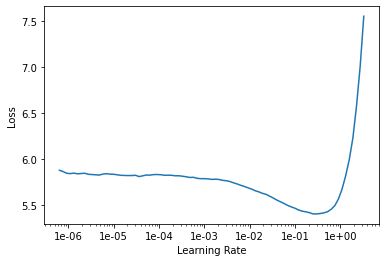

In [9]:
# use the learning rate finder 
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,3.824706,3.460586,0.354959,22:34
1,3.284447,3.077788,0.409196,22:35
2,3.050486,2.927853,0.433044,22:32
3,2.919732,2.845652,0.447642,22:34
4,2.740261,2.829612,0.450455,22:35


In [11]:
# To complete the fine-tuning, we can then unfeeze and launch a new training.
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


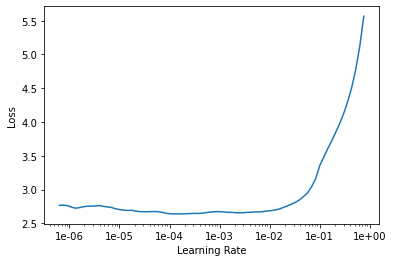

In [12]:
# use the learning rate finder again
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,2.607866,2.673299,0.477179,39:43
1,2.339015,2.487783,0.511007,39:47
2,2.056129,2.372043,0.538652,39:50
3,1.901287,2.314432,0.553811,39:48
4,1.677666,2.317137,0.557163,39:11


In [14]:
learn.save_encoder('fine_tuned_enc')

In [15]:
cat_names = ['Title','LocationNormalized','ContractType','ContractTime','Company','Category'] # categorical
cont_names = [] # continous variables (in our case we don't have any) 
dep_var = 'SalaryNormalized' # label
procs = [FillMissing, Categorify, Normalize] # preprocessing steps
txt_cols=['FullDescription'] # text
bs = 8 # batch size

# import numpy as np

# np.random.seed(42)

In [16]:
# get tabular Databunch from the fast.ai Tabular module (docs: https://docs.fast.ai/tabular.data.html)
def get_tab_databunch(df,bs=bs,val_idxs=val_idxs, path = MODEL_TEXT_TAB_PATH):
        
    return (TabularList.from_df(df, cat_names, cont_names, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols = dep_var, label_cls = FloatList)
#                             .label_from_df(cols=dep_var)
                            .databunch(bs=bs))

# get Text Databunch from the fast.ai Text module (docs: https://docs.fast.ai/text.data.html)
def get_text_databunch(df,bs=bs,val_idxs=val_idxs, path = MODEL_TEXT_TAB_PATH):
    # load fine-tuned vocab
    data_lm =load_data(MODEL_LM_PATH, 'data_lm.pkl', bs=bs)
    return (TextList.from_df(df, cols = txt_cols[0], vocab=data_lm.vocab, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols = dep_var, label_cls = FloatList)
#                             .label_from_df(cols=dep_var)
                            .databunch(bs=bs))

In [17]:
# get fast.ai tabular learner (docs: https://docs.fast.ai/tabular.models.html)
def get_tabular_learner(data, params):
    return tabular_learner(data,metrics=accuracy,**params)

# get fast.ai text learner and load the fine-tuned weights (docs: https://docs.fast.ai/text.learner.html)
def get_text_learner(data, params):
    learn = text_classifier_learner(data,AWD_LSTM,metrics=accuracy,**params)
    learn.path=MODEL_LM_PATH
    learn.load_encoder('fine_tuned_enc')
    learn.path=MODEL_TEXT_TAB_PATH
    return learn

In [18]:
def get_data(bs=bs,path=MODEL_TEXT_TAB_PATH):
    
    tb_data = df_all[cat_names + cont_names + [dep_var]]
    
    print(tb_data) 
    
    
    # get databunches using fast.ai's implementation
    tab_db = get_tab_databunch(df_all[cat_names + cont_names+ [dep_var]])
    text_db = get_text_databunch(df_all[txt_cols +[dep_var]])
    
    # extend the databunches to work with our Concat Model
    train_ds = ConcatDataset(tab_db.train_ds.x, text_db.train_ds.x, tab_db.train_ds.y)
    valid_ds = ConcatDataset(tab_db.valid_ds.x, text_db.valid_ds.x, tab_db.valid_ds.y)
    
    # add sample startegies for both training and validation set
    train_sampler = SortishSampler(text_db.train_ds.x, key=lambda t: len(text_db.train_ds[t][0].data), bs=bs//2)
    valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda t: len(text_db.valid_ds[t][0].data))
    
    # create DataLoaders
    train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
    valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
    
    # create databunch to work with out Concat Model
    data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=tabtext_collate, path=path)

    return data,tab_db,text_db

In [19]:
# instantiate all necessary DataBunches
data,tab_db,text_db = get_data(bs=bs)

      Title  LocationNormalized  ContractType  ContractTime  Company  \
0      1779                 153             2             1      166   
1      3023                  77             2             1      166   
2       895                 651             3             1      289   
3      2889                 558             2             3      315   
4      3195                  77             1             3      315   
...     ...                 ...           ...           ...      ...   
4995    843                  77             3             1      289   
4996   2893                 325             3             3      280   
4997    672                 305             2             1      126   
4998    927                 599             1             3      315   
4999   1079                 400             3             3      315   

      Category  SalaryNormalized  
0           20          0.337090  
1            6          0.171362  
2           16          0.2231

C:\Users\rishu\anaconda3\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [20]:
# custom module to concatentate the outputs of the tabular and text submodules and add the Multilayer Perceptron on top
class ConcatModel(nn.Module):
    def __init__(self, mod_tab, mod_nlp, layers, drops):
        super().__init__()
        self.mod_tab = mod_tab
        self.mod_nlp = mod_nlp
        lst_layers = []
        activs = [nn.Sigmoid(), ] * (len(layers)-2) + [None]
        for n_in, n_out, p, actn in zip(layers[:-1], layers[1:], drops, activs):
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*lst_layers)

    def forward(self, *x):
        x_tab = self.mod_tab(*x[0])
        x_nlp = self.mod_nlp(x[1])[0]
        x = torch.cat([x_tab, x_nlp], dim=1)
        return self.layers(x)

In [21]:
def get_concat_learner(data, tab_db, text_db):
    
    # output size of the last layer of the tabular module
    tab_out_size = 100
    # output size of the last layer of the text module (ULMFiT)
    text_out_size = 300
    
    params = {
        'layers': [tab_out_size], # output size of the last layer of the tabular module
        'ps': [0.], # dropout before the last layer of the tabular module
        'emb_drop': 0., # embedding dropout for categorical features
        'use_bn': True, # use batchnorm
    }
    
    # instantiate the tabular learner
    tab_learner = get_tabular_learner(tab_db, params)
    # cut off layers so we can put the Concat head on top
    tab_learner.model.layers = tab_learner.model.layers[:-2]

    params = {
        'lin_ftrs': [text_out_size],  # output size of the last layer of the text module (ULMFiT)
        'bptt': 80, # backpropagation through time (sequence length)
        'max_len': 20*80, # last max_len activations to be considered (see https://docs.fast.ai/text.learner.html)
        'drop_mult': 1. # dropout rate
    }
    
    # instantiate the text learner
    text_learner = get_text_learner(text_db, params)
    # cut off layers so we can put the Concat head on top
    text_learner.model[-1].layers = text_learner.model[-1].layers[:-3]
    
    # size of fully connected layers in Concat Head
    lin_layers = [tab_out_size + text_out_size, 200, 1]
    # dropout rate for fully connected layers in Concat Head
    ps = [0.3, 0.2, 0.1]
    model = ConcatModel(tab_learner.model, text_learner.model, lin_layers, ps)
    
    # Use Mean Squared Error here if you want to use this for a regression task
    loss_func = MSELossFlat()
   
    learn = Learner(data, model, loss_func=loss_func, metrics=mean_absolute_error)
    
    return learn

In [22]:
# instantiate the learner object
print(tab_db)
print(text_db)
learner = get_concat_learner(data,tab_db,text_db)

TabularDataBunch;

Train: LabelList (4000 items)
x: TabularList
Title 1779; LocationNormalized 153; ContractType 2; ContractTime 1; Company 166; Category 20; ,Title 3023; LocationNormalized 77; ContractType 2; ContractTime 1; Company 166; Category 6; ,Title 895; LocationNormalized 651; ContractType 3; ContractTime 1; Company 289; Category 16; ,Title 2889; LocationNormalized 558; ContractType 2; ContractTime 3; Company 315; Category 18; ,Title 3195; LocationNormalized 77; ContractType 1; ContractTime 3; Company 315; Category 18; 
y: FloatList
0.33708984,0.17136228,0.22315213,0.34399512,0.21279417
Path: models_text_tab;

Valid: LabelList (1000 items)
x: TabularList
Title #na#; LocationNormalized 325; ContractType 2; ContractTime 3; Company 315; Category 18; ,Title #na#; LocationNormalized 502; ContractType 2; ContractTime 1; Company 222; Category 15; ,Title #na#; LocationNormalized 367; ContractType 2; ContractTime 3; Company 315; Category 18; ,Title #na#; LocationNormalized 607; Contrac

In [23]:
learner.model

ConcatModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(3412, 152)
      (1): Embedding(637, 59)
      (2): Embedding(4, 3)
      (3): Embedding(4, 3)
      (4): Embedding(281, 38)
      (5): Embedding(29, 11)
    )
    (emb_drop): Dropout(p=0.0, inplace=False)
    (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=266, out_features=100, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (mod_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(8064, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(8064, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): WeightDropout(
            (module): LSTM(400, 1152, batch_first=True)
          )
          (1): WeightDropout(
            (module): LSTM(1152, 1152, batch_first=True)
          )
          (2): Wei

epoch,train_loss,valid_loss,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


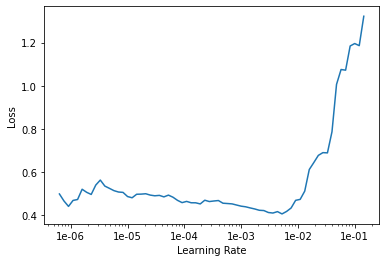

In [24]:
# use the learning rate finder 
learner.lr_find()
learner.recorder.plot(skip_end=1)

In [ ]:
learner.fit_one_cycle(5, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.042498,0.048305,0.188208,39:30
1,0.010877,0.011063,0.066017,41:01
